# Can a simple DNN yield valuable results ?

This is an attempt to see how much a simple deep neural network is able to perform. I also intend to use this kernel as the primay basic block and improve its future performances.


In [1]:
import pandas as pd

from sklearn.model_selection import KFold

from tensorflow import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

random.set_seed(5577)

## **Data Preparation**

In [2]:
trainFeatures        = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
trainTargetScored    = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
testFeatures         = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
sampleSubmission     = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [3]:
trainFeatures['cp_type'] = trainFeatures['cp_type'].map({'trt_cp':0, 'ctl_vehicle':1})
trainFeatures['cp_dose'] = trainFeatures['cp_dose'].map({'D1':0, 'D2':1})
trainFeatures = trainFeatures.drop(columns="sig_id")
trainTargetScored = trainTargetScored.drop(columns="sig_id")

testFeatures['cp_type'] = testFeatures['cp_type'].map({'trt_cp':0, 'ctl_vehicle':1})
testFeatures['cp_dose'] = testFeatures['cp_dose'].map({'D1':0, 'D2':1})
testFeatures = testFeatures.drop(columns="sig_id")

featuresCount = trainFeatures.shape[1]
print("Features count = %d" % featuresCount)

targetsCols  = trainTargetScored.columns
targetsCount = len(targetsCols)
print("Targets count = %d" % targetsCount)

Features count = 875
Targets count = 206


## **Model Creation**

In [4]:
def getModel(hiddenLayerSize=1024, dropOut=0.2):
	model = Sequential()
	model.add(Dense(hiddenLayerSize, input_dim=featuresCount, activation='relu'))
	model.add(Dropout(dropOut))
	model.add(Dense(hiddenLayerSize,activation='relu'))
	model.add(Dropout(dropOut))
	model.add(Dense(hiddenLayerSize,activation='relu'))
	model.add(Dropout(dropOut)) 
	model.add(Dense(targetsCount, activation="sigmoid"))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[])
	return model

## **Hyperparameters**
Hyperparameters were set by few trial and error testing.


In [5]:
nSplits = 13
batchSize = 1000
epochCount = 12
hiddenLayerSize = 1024
dropOut = 0.2

## **Fitting the model**


In [6]:
models = []
losses = []
history = {}
verbosity = 0

kfold = KFold(n_splits=nSplits, shuffle=True)
for j, (train_idx, val_idx) in enumerate(kfold.split(trainFeatures)):
	model = getModel(hiddenLayerSize, dropOut)
	history[j] = model.fit(trainFeatures.values[train_idx], trainTargetScored.values[train_idx], validation_data=(trainFeatures.values[val_idx], trainTargetScored.values[val_idx]), batch_size=batchSize, epochs=epochCount, verbose=verbosity)
	scores = model.evaluate(trainFeatures.values[val_idx], trainTargetScored.values[val_idx], verbose=verbosity)
	losses.append(history[j].history["val_loss"][-1])
	print('Fold %d: %s of %.6f' % (j,model.metrics_names[0],scores))
	models.append(model)
print(losses)

Fold 0: loss of 0.015153
Fold 1: loss of 0.015575
Fold 2: loss of 0.015571
Fold 3: loss of 0.015378
Fold 4: loss of 0.016388
Fold 5: loss of 0.015881
Fold 6: loss of 0.015781
Fold 7: loss of 0.016387
Fold 8: loss of 0.015488
Fold 9: loss of 0.016342
Fold 10: loss of 0.016165
Fold 11: loss of 0.016408
Fold 12: loss of 0.015932
[0.01515304483473301, 0.015575396828353405, 0.015570802614092827, 0.015378114767372608, 0.016387883573770523, 0.0158807672560215, 0.01578095555305481, 0.016387440264225006, 0.015488257631659508, 0.016342293471097946, 0.016164835542440414, 0.01640787534415722, 0.015932220965623856]


## **Plotting the loss & validation loss**

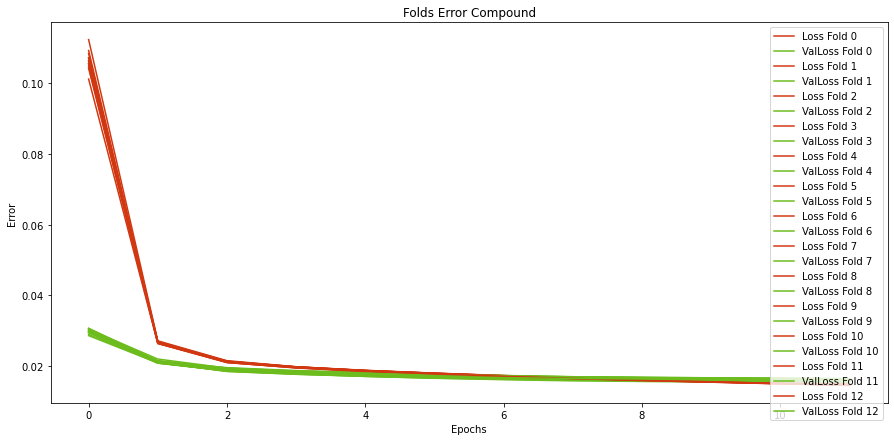

In [7]:
plt.figure(figsize=(15,7))
for k,v in history.items():
	plt.plot(v.history["loss"], color='#d13812', label="Loss Fold "+str(k))
	plt.plot(v.history["val_loss"], color='#6dbc1e', label="ValLoss Fold "+str(k))

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Folds Error Compound')
plt.legend()
plt.show()

## **Making the prediction & submitting results**

In [8]:
predictions = sampleSubmission.copy()
predictions[targetsCols] = 0
for model in models:
    predictions.loc[:,targetsCols] += model.predict(testFeatures)
predictions.loc[:,targetsCols] /= len(models)
predictions.to_csv('submission.csv', index=False)